In [140]:
import pickle
import numpy as np
from load_pickle import get_outputs
from itertools import product
import matplotlib.pyplot as plt
from scipy import io
from scipy import stats
import pandas as pd
import seaborn as sns
import os

cwd = os.getcwd()

from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from utils import *

data_folder = '/Users/kendranoneman/temp_data/'
fig_folder='/Users/kendranoneman/Projects/mayo/NeuralDecoding/figures/' 

colors2 = ['purple', 'blue','cyan','mediumaquamarine','green','yellowgreen','gold','orange', 'magenta', 'red','gray'] #Colors to plot each method
colors = ['mediumorchid','seagreen','cornflowerblue','gold']

sessions = [18,20,22,24,29]
comb_neurons = [[2,0],[4,0],[6,0],[8,0],[10,0],[12,0],[14,0],[16,0],[18,0],[20,0],[0,2],[0,4],[0,6],[0,8],[0,10],[0,12],[0,14],[0,16],[0,18],[0,20],[2,2],[4,4],[6,6],[8,8],[10,10],[12,12],[14,14],[16,16],[18,18],[20,20]]

In [141]:
def get_outputs(result_dir,load_folder):
    #print(result_dir)
    num_folds = int(result_dir[35:37])
    num_repeats = int(result_dir[-5:-1])
    sess = int(result_dir[1:3])
    num_mt = int(result_dir[21:23])
    num_fef = int(result_dir[26:28])
    
    pairs = list(product(range(num_folds), range(num_repeats)))
    
    R2s = []
    for j in range(len(pairs)):
        thisfile = data_folder+result_dir+'fo'+str(pairs[j][0])+'_re'+str(pairs[j][1])+'.pickle'
        if os.path.isfile(thisfile):
            try:
                with open(thisfile,'rb') as f:
                    y_train0,y_test0,y_train_pred0,y_test_pred0,r2s,rhs,te,params,ninds=pickle.load(f,encoding='latin1')
            except ValueError:
                with open(thisfile,'rb') as f:
                    y_test0,y_test_pred0,r2s,rhs,te,params,ninds=pickle.load(f,encoding='latin1')
            
            R2s.append([sess,num_mt,num_fef,r2s])
            #print(r2s)
                
    df = pd.DataFrame(R2s,columns=['sess','mt','fef','R2'])
    return df

In [142]:
DF = pd.DataFrame()
for sn in comb_neurons:
    print(sn)
    for s in sessions:
        data_dirs = ['s{:0>2d}-t0-d050-m00-o0-nm{:0>2d}-nf{:0>2d}-bn0-fo10-fi03-r0050/'.format(s,sn[0],sn[1])]
        for i in range(len(data_dirs)):
            df = get_outputs(data_dirs[i],data_folder)
            DF = pd.concat([DF,df],ignore_index=True)
            

print(DF.shape)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(DF)

[2, 0]
[4, 0]
[6, 0]
[8, 0]
[10, 0]
[12, 0]
[14, 0]
[16, 0]
[18, 0]
[20, 0]
[0, 2]
[0, 4]
[0, 6]
[0, 8]
[0, 10]
[0, 12]
[0, 14]
[0, 16]
[0, 18]
[0, 20]
[2, 2]
[4, 4]
[6, 6]
[8, 8]
[10, 10]
[12, 12]
[14, 14]
[16, 16]
[18, 18]
[20, 20]
(73000, 4)


,mt,fef,R2
500,2,0,-0.000566
501,2,0,-0.003320
502,2,0,-0.002245
503,2,0,0.001408
504,2,0,-0.001451
505,2,0,0.008404
506,2,0,-0.003301
507,2,0,-0.002774
508,2,0,-0.003627
509,2,0,-0.000069


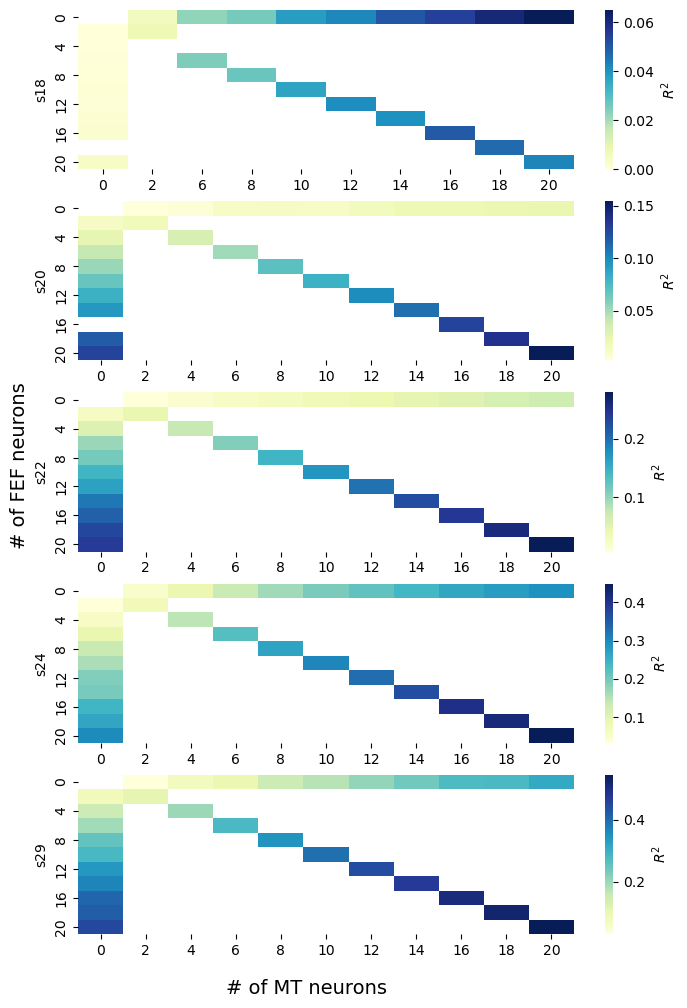

In [174]:
fig, axes = plt.subplots(5,1,figsize=(8,12)) #Create figure (11 rows by 3 columns)

for s in range(len(sessions)):
    df = DF[DF['sess']==sessions[s]]
    df = df[['mt','fef','R2']]

    df_m = df.groupby(['fef', 'mt'])["R2"].mean().reset_index(name="mean_R2")
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(df_m)

    result = df_m.pivot(index='fef', columns='mt', values='mean_R2')

    a = sns.heatmap(ax=axes[s],data=result, cmap="YlGnBu", mask=result.isnull(),cbar_kws={'label': '$R^2$'})
    a.set(ylabel='s'+str(sessions[s]))
    a.set(xlabel=None)

fig.text(0.04, 0.5, '# of FEF neurons', va='center', rotation='vertical', fontsize=14)
fig.text(0.41, 0.06, '# of MT neurons', ha='center', fontsize=14)

fig.savefig(fig_folder+'r2_numNeurons-heatmap.png', dpi=300, bbox_inches='tight') 

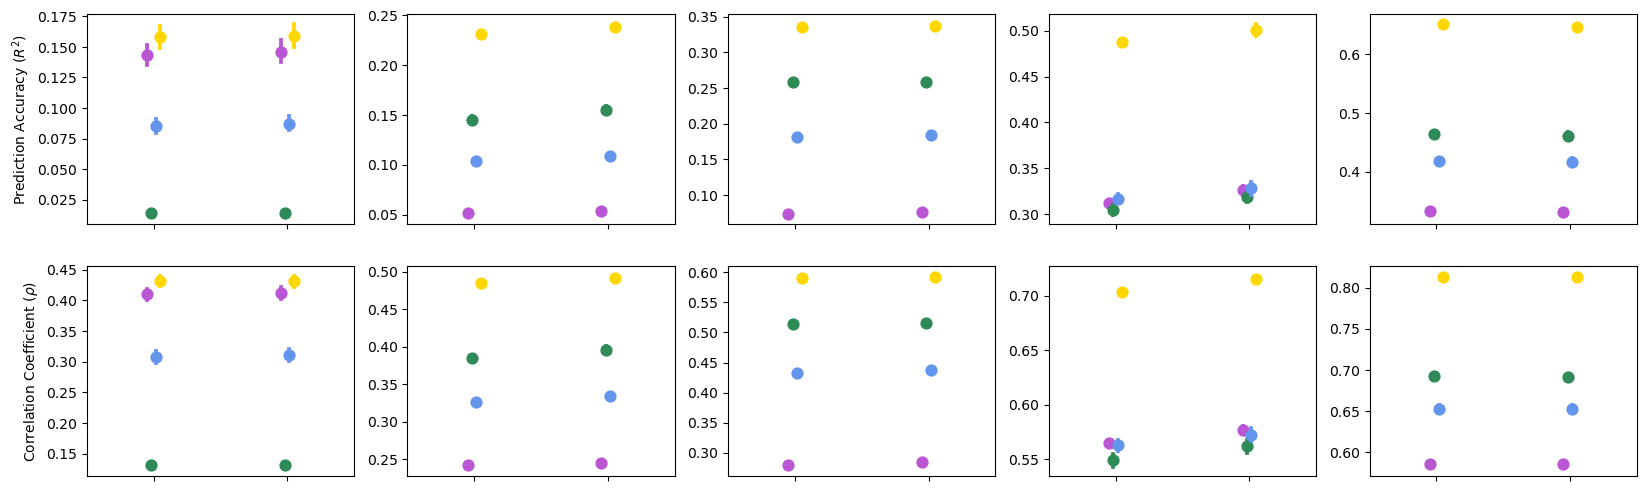

In [5]:
fig, axes = plt.subplots(2,5,figsize=(20,6)) #Create figure (11 rows by 3 columns)

a = sns.pointplot(ax=axes[m,s],data=df.loc[df['sess'] == 18],x="model",y="r2",hue="Brain Area",join=False,palette=colors,errorbar='sd',dodge=True)
#a.set(ylim=(0.3, 0.8))
a.set(ylabel='Prediction Accuracy ($R^2$)')
#a.set(title='MT only')
a.set(xticklabels=[])
a.set(xlabel=None)
a.get_legend().remove()

#fig.legend(bbox_to_anchor=(0.9,0.5), loc="center left")


292
279
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dnn_mt+fef vs. dnn_all: Mann-Whitney-Wilcoxon test two-sided, P_val:1.733e-116 U_stat=8.064e+03
wc_mt+fef vs. wc_all: Mann-Whitney-Wilcoxon test two-sided, P_val:2.242e-25 U_stat=1.910e+04
dnn_mt only vs. dnn_fef only: Mann-Whitney-Wilcoxon test two-sided, P_val:3.617e-140 U_stat=1.798e+05
wf_mt+fef vs. wf_all: Mann-Whitney-Wilcoxon test two-sided, P_val:2.015e-28 U_stat=2.011e+04
wf_mt only vs. wf_fef only: Mann-Whitney-Wilcoxon test two-sided, P_val:1.671e-77 U_stat=8.062e+04
wf_fef only vs. wf_mt+fef: Mann-Whitney-Wilcoxon test two-sided, P_val:2.956e-71 U_stat=6.242e+03
wc_mt only vs. wc_fef only: Mann-Whitney-Wilcoxon test two-sided, P_val:4.131e-77 U_stat=7.431e+04
wc_fef only vs. wc_mt+fef: Mann-Whitney-Wilcoxon test two-sided, P_val:3.358e-69 U_stat=5.439e+03
dnn_fef only vs. dnn_mt+fef: Mann

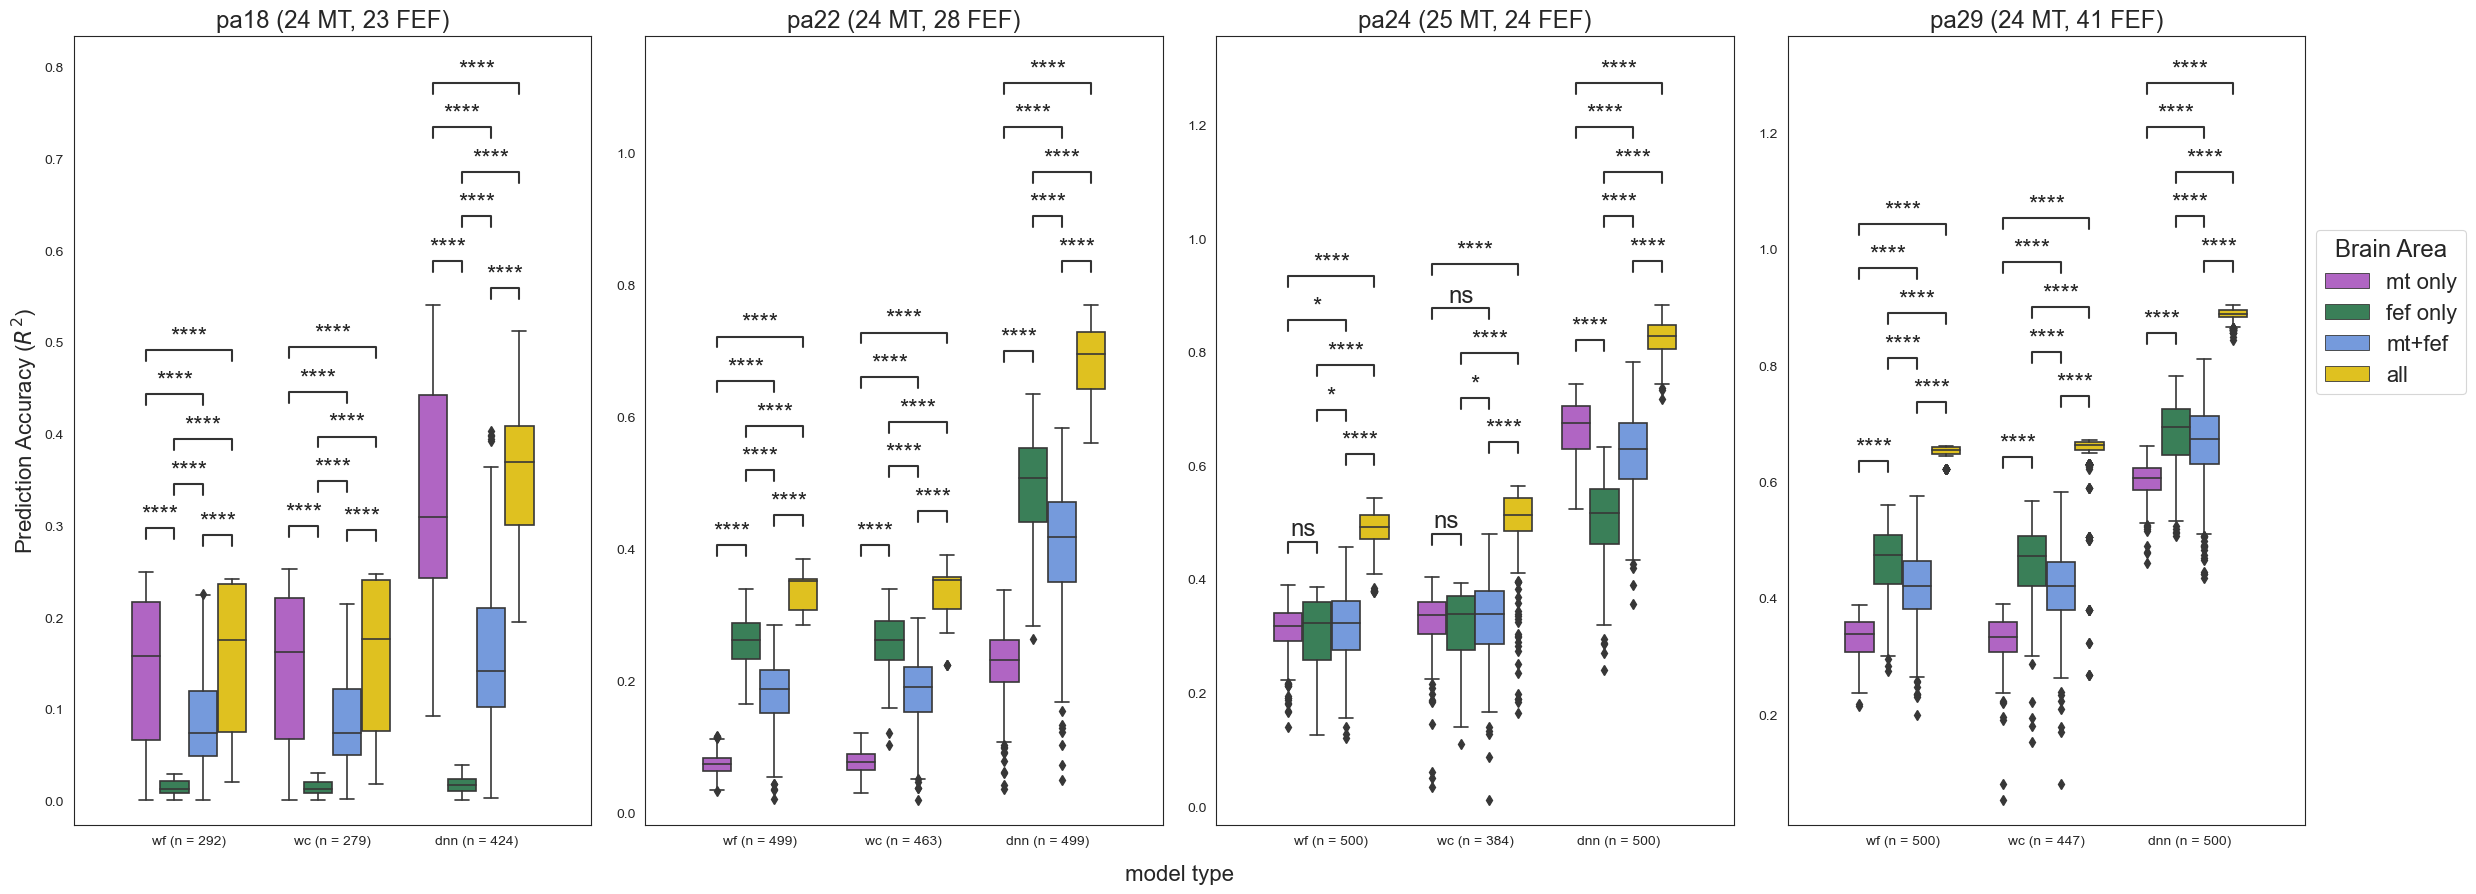

In [102]:
import matplotlib as mpl
import matplotlib.patheffects as path_effects

pairs = [
    [('wf', 'mt only'), ('wf', 'fef only')],
    [('wf', 'mt only'), ('wf', 'mt+fef')],
    [('wf', 'mt only'), ('wf', 'all')],
    [('wf', 'fef only'), ('wf', 'mt+fef')],
    [('wf', 'fef only'), ('wf', 'all')],
    [('wf', 'mt+fef'), ('wf', 'all')],

    [('wc', 'mt only'), ('wc', 'fef only')],
    [('wc', 'mt only'), ('wc', 'mt+fef')],
    [('wc', 'mt only'), ('wc', 'all')],
    [('wc', 'fef only'), ('wc', 'mt+fef')],
    [('wc', 'fef only'), ('wc', 'all')],
    [('wc', 'mt+fef'), ('wc', 'all')],
    
    [('dnn', 'mt only'), ('dnn', 'fef only')],
    [('dnn', 'mt only'), ('dnn', 'mt+fef')],
    [('dnn', 'mt only'), ('dnn', 'all')],
    [('dnn', 'fef only'), ('dnn', 'mt+fef')],
    [('dnn', 'fef only'), ('dnn', 'all')],
    [('dnn', 'mt+fef'), ('dnn', 'all')]
     
]

'''
[('xgb', 'mt only'), ('xgb', 'fef only')],
[('xgb', 'mt only'), ('xgb', 'mt+fef')],
[('xgb', 'fef only'), ('xgb', 'mt+fef')],

[('svr', 'mt only'), ('svr', 'fef only')],
[('svr', 'mt only'), ('svr', 'mt+fef')],
[('svr', 'fef only'), ('svr', 'mt+fef')],

[('dnn', 'mt only'), ('dnn', 'fef only')],
[('dnn', 'mt only'), ('dnn', 'mt+fef')],
[('dnn', 'fef only'), ('dnn', 'mt+fef')],

[('rnn', 'mt only'), ('rnn', 'fef only')],
[('rnn', 'mt only'), ('rnn', 'mt+fef')],
[('rnn', 'fef only'), ('rnn', 'mt+fef')],

[('gru', 'mt only'), ('gru', 'fef only')],
[('gru', 'mt only'), ('gru', 'mt+fef')],
[('gru', 'fef only'), ('gru', 'mt+fef')],

'''

fig, axes = plt.subplots(1, len(sessions), figsize=(23, 9))
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

for s in range(len(sessions)):
    with sns.plotting_context("paper", font_scale = 1.8):
        hue_plot_params = [[],[],[]]
        hue_plot_params[0] = {'data': df.loc[df['sess'] == sessions[s]],'x': 'model','y': 'r2',"hue": "Brain Area","palette": colors}
        hue_plot_params[1] = {'data': df.loc[df['sess'] == sessions[s]],'x': 'model','y': 'rho',"hue": "Brain Area","palette": colors}
        hue_plot_params[2] = {'data': df.loc[df['sess'] == sessions[s]],'x': 'model','y': 'time',"hue": "Brain Area","palette": colors}

        wf_size = int((df[(df['sess']==sessions[s]) & (df['model']=='wf')].shape[0])/4)
        wc_size = int((df[(df['sess']==sessions[s]) & (df['model']=='wc')].shape[0])/4)
        dnn_size = int((df[(df['sess']==sessions[s]) & (df['model']=='dnn')].shape[0])/4)
        print(wf_size)
        print(wc_size)
       
        a1 = sns.boxplot(ax=axes[s], **hue_plot_params[0])
        annotator = Annotator(axes[s], pairs, **hue_plot_params[0])
        annotator.configure(test="Mann-Whitney").apply_and_annotate()
        axes[s].set_xticklabels(['wf (n = {})'.format(wf_size),'wc (n = {})'.format(wc_size),'dnn (n = {})'.format(dnn_size)], rotation=0)
        a1.set(xlabel=None)
        a1.set(title='pa' + str(sessions[s])+' ({} MT, {} FEF)'.format(mt_perSess[s],fef_perSess[s]))
        
        if s==0:
            a1.set_ylabel('Prediction Accuracy ($R^2$)', fontsize = 16)
        else:
            a1.set(ylabel=None)
        
        if s!=len(sessions)-1:
            a1.get_legend().remove()
        else:    
            sns.move_legend(a1, "center left", bbox_to_anchor=(1, 0.65))  
            
fig.text(0.5, 0.01, 'model type', ha='center', fontsize=16)
fig.savefig(fig_folder+'ffmodels_r2_3sess.png', dpi=300, bbox_inches='tight')        

In [ ]:
mt_wf = df.loc[(df['Brain Area']=='mt only') & (df['model']=='wf'), "r2"].values
fef_wf =  df.loc[(df['Brain Area']=='fef only') & (df['model']=='wf'), "r2"].values
mtfef_wf = df.loc[(df['Brain Area']=='mt+fef') & (df['model']=='wf'), "r2"].values

stat_results = [
  mannwhitneyu(mt_wf, fef_wf, alternative="two-sided"),
  mannwhitneyu(fef_wf, mtfef_wf, alternative="two-sided"),
  mannwhitneyu(mt_wf, mtfef_wf, alternative="two-sided")
]

pvalues = [result.pvalue for result in stat_results]

print("MT vs FEF: \n", stat_results[0], "\n")
print("FEF vs MT+FEF: \n", stat_results[1], "\n")
print("MT vs MT+FEF: \n", stat_results[2], "\n")

NameError: name 'y_test' is not defined

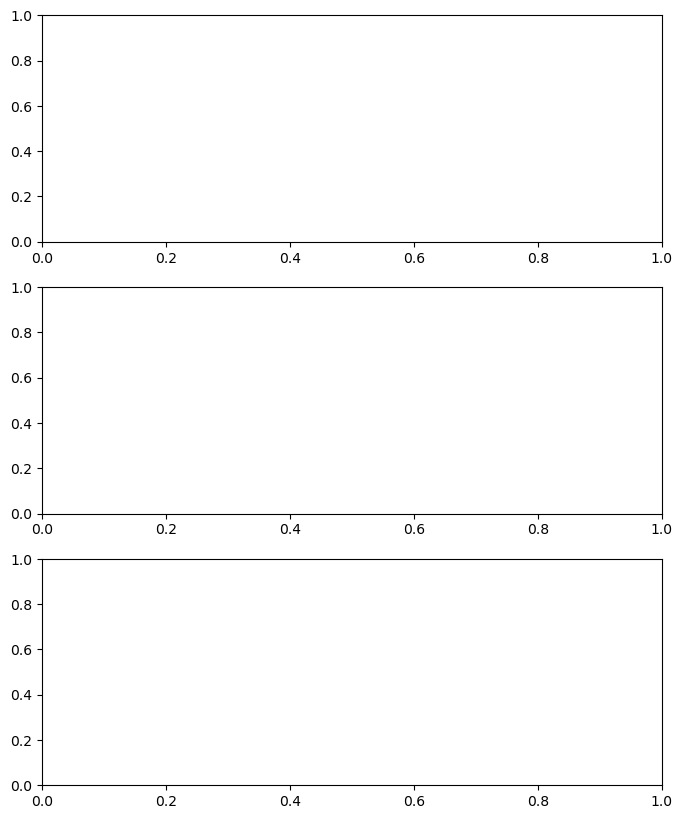

In [175]:
ts=np.arange(0,500) #Plot samples 500-800
samp = 4

fig_traces, ax = plt.subplots(3,1,figsize=(8,10)) #Create figure (11 rows by 3 columns)

m=0 #Initialize method number. This corresponds to the row we're currently plotting in.
x = (ts*50)/1000

#WF (mix FEF + MT)
ax[m].plot(x,np.array(y_test[samp])[ts,0],'k') #Plot actual
ax[m].plot(x,np.array(y_test_pred_wf[0][0])[ts,0],colors[m]) #Plot predictions, in color specified in user options section
ax[m].tick_params(direction='in') #Make ticks inward
ax[m].set_title('MT Only (R2 = {:.4f})'.format(np.mean(R2s_wf[m])))
#ax[m].set_ylim([-100,100])
#ax[m].set_yticks(np.arange(-100,100.1,50))
#ax[m].set_xlim([0,t_len]) #Set x limit
ax[m].spines['right'].set_color('none') #Remove right boundary
ax[m].spines['top'].set_color('none') #Remove top boundary
if ill:
    ax[m].set_xticklabels('')
    ax[m].set_yticklabels('')
m=m+1 

#WF (FEF only)
ax[m].plot(x,np.array(y_test[samp])[ts,0],'k') #Plot actual
ax[m].plot(x,np.array(y_test_pred_wf[1][0])[ts,0],colors[m]) #Plot predictions, in color specified in user options section
ax[m].tick_params(direction='in') #Make ticks inward
ax[m].set_title('FEF Only (R2 = {:.4f})'.format(np.mean(R2s_wf[m])))
#ax[m].set_ylim([-100,100])
#ax[m].set_yticks(np.arange(-100,100.1,50))
#ax[m].set_xlim([0,t_len]) #Set x limit
ax[m].spines['right'].set_color('none') #Remove right boundary
ax[m].spines['top'].set_color('none') #Remove top boundary
if ill:
    ax[m].set_xticklabels('')
    ax[m].set_yticklabels('')
m=m+1

#WF (MT only)
ax[m].plot(x,np.array(y_test[samp])[ts,0],'k') #Plot actual
ax[m].plot(x,np.array(y_test_pred_wf[2][0])[ts,0],colors[m]) #Plot predictions, in color specified in user options section
ax[m].tick_params(direction='in') #Make ticks inward
ax[m].set_title('MT + FEF (R2 = {:.4f})'.format(np.mean(R2s_wf[m])))
#ax[m].set_ylim([-100,100])
#ax[m].set_yticks(np.arange(-100,100.1,50))
#ax[m].set_xlim([0,t_len]) #Set x limit
ax[m].spines['right'].set_color('none') #Remove right boundary
ax[m].spines['top'].set_color('none') #Remove top boundary
if ill:
    ax[m].set_xticklabels('')
    ax[m].set_yticklabels('')
m=m+1 #Increase method index, so the next method gets plotted on the next row

